# Stock Price Predictor
This Notebook uses historical data from the S&P 500 index to predict the following day's price for a given stock.

## Load Data

In [2]:
import yfinance as yf  # yahoo finance
sp500 = yf.Ticker("^GSPC")  # initialize index
sp500 = sp500.history(period="max")  # query: get history since start of index

sp500

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1927-12-30 00:00:00-05:00,17.660000,17.660000,17.660000,17.660000,0,0.0,0.0
1928-01-03 00:00:00-05:00,17.760000,17.760000,17.760000,17.760000,0,0.0,0.0
1928-01-04 00:00:00-05:00,17.719999,17.719999,17.719999,17.719999,0,0.0,0.0
1928-01-05 00:00:00-05:00,17.549999,17.549999,17.549999,17.549999,0,0.0,0.0
1928-01-06 00:00:00-05:00,17.660000,17.660000,17.660000,17.660000,0,0.0,0.0
...,...,...,...,...,...,...,...
2023-04-27 00:00:00-04:00,4075.290039,4138.240234,4075.290039,4135.350098,3750550000,0.0,0.0
2023-04-28 00:00:00-04:00,4129.629883,4170.060059,4127.180176,4169.479980,4087800000,0.0,0.0
2023-05-01 00:00:00-04:00,4166.790039,4186.919922,4164.120117,4167.870117,3321370000,0.0,0.0


<Axes: xlabel='Date'>

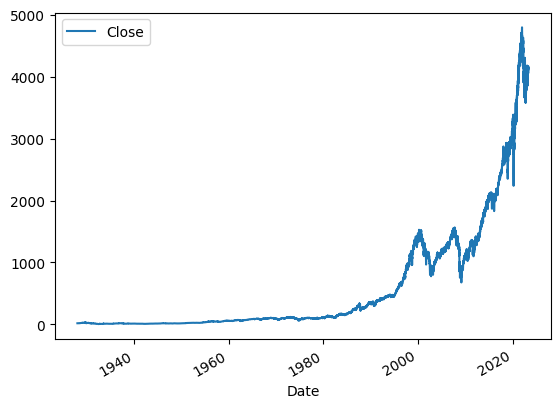

In [3]:
sp500.plot.line(y="Close", use_index=True)

## Data Engineering

A time series-based approach to making predictions.

In [4]:
# Remove unwanted columns
del sp500["Dividends"]
del sp500["Stock Splits"]

# Remove old data. Data from too long ago is detrimental to our predictions.
sp500 = sp500.loc["1990-01-01":].copy()  # use copy() to avoid complicated pandas errors

In [5]:
# A column linking each day's price to the next day's
sp500["Tomorrow"] = sp500["Close"].shift(-1)

# A column containing 1 if the stock went up, else 0
sp500["Target"] = (sp500["Tomorrow"] > sp500["Close"]).astype(int)

### Splitting the data
Since we are dealing with time series data, we cannot rely on cross validation, or any means of evaluation that involves randomly splitting the data. This is because each entry is dependent on previous entries, and so random subsets would lose this definitive feature. This is an instance of Data Leakage.

In [6]:
# Training set
train = sp500.iloc[:-100]
valid = sp500.iloc[-100:]

features = ["Close", "High", "Low", "Volume", "Open"]

## Training the Initial Model

Here we use sci-kit Learn's RandomForestClassifier model.

In [7]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(
    n_estimators=100,  # number of decision trees
    min_samples_split=100,  # avoid overfitting
    random_state=7  # seed
)

model.fit(train[features], train["Target"])

RandomForestClassifier(min_samples_split=100, random_state=7)

In [8]:
# Validation
from sklearn.metrics import precision_score
import pandas as pd

predictions = model.predict(valid[features])
predictions = pd.Series(predictions, index=valid.index)

precision_score(valid["Target"], predictions)

0.5454545454545454

<Axes: xlabel='Date'>

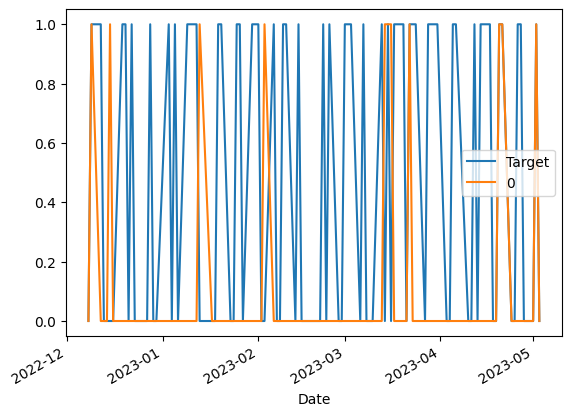

In [9]:
# Visualize results
combined = pd.concat([valid["Target"], predictions], axis=1)
combined.plot()

# Evaluating the Model
The predict function encapsulates the entire training process from above, allowing us to focus only on parameters.

backtest, on the other hand, is a function that predicts the target for every row of the data by using all entries prior to that date. Note that this method of evaluation for our model is not an instance of data leakage: Assuming our model picked up non-linear trends when training, the predictions it makes are not effectively based on specific entries in the dataset, such as those from a time ahead of a given date.

In [15]:
def predict(train: pd.DataFrame, 
            valid: pd.Series, 
            features: list[str], 
            model: RandomForestClassifier  # or any model with equivalent fit/predict methods
            ) -> pd.DataFrame:
    """
    Return a DataFrame containing 2 rows:
    - The target data as "Target"
    - The corresponding predictions as "Predictions"
    """
    model.fit(train[features], train["Target"])
    preds = model.predict(valid[features])
    preds = pd.Series(preds, index=valid.index, name="Predictions")
    return pd.concat([valid["Target"], preds], axis=1)


def backtest(data: pd.DataFrame,
             model: RandomForestClassifier,
             features: list[str],
             start=2500,
             step=250
             ) -> pd.DataFrame:
    """Return a DataFrame showing the model's predictions for every entry in the data."""
    allPredictions = []
    for i in range(start, data.shape[0], step):
        train = data.iloc[0:i].copy()
        valid = data.iloc[i:(i+step)].copy()
        results = predict(train, valid, features, model)
        allPredictions.append(results)
    return pd.concat(allPredictions)


In [18]:
# This one takes a while to run, expectedly
btPreds = backtest(sp500, model, features)
btPreds["Predictions"].value_counts()  # shows how many times the model predicted each outcome

Predictions
0    3452
1    2447
Name: count, dtype: int64

In [19]:
# Check our backtesting precision score
precision_score(btPreds["Target"], btPreds["Predictions"])

0.526767470371884

# More Feature Engineering
We may use our insights to enhance our model. First, add some columns that link each date to the rolling average from the past {bench} amount of days. With this, we introduce a ratioCol, which represents the change in the close value over this interval. Similarly, we create a trendCol that represents the number of days the stock price went up within the past {bench} days.

In [21]:
# Use past benchmark dates to predict if a market crash is due
benchmarks = [2, 5, 50, 250, 1000]
newFeatures = []

for bench in benchmarks:
    rollingAvgs = sp500.rolling(bench).mean()
    ratioCol = f"Close_Ratio_{bench}"
    sp500[ratioCol] = sp500["Close"] / rollingAvgs["Close"]

    trendCol = f"Trend_{bench}"
    sp500[trendCol] = sp500.shift(1).rolling(bench).sum()["Target"]

    newFeatures += [ratioCol, trendCol]

When we create these new rows above, many of the rows at the start of the dataset will not have access to {bench} amount of prior entries. When this happens, pandas fills in the value with NaN. For our matter, we will drop these entries. However, if we wanted to include data from exactly 1990 as we initially chose, we would have to start with data from {bench} days before, so that we would cutoff exactly everything before 1990-01-01.

In [24]:
sp500 = sp500.dropna()
sp500

,Open,High,Low,Close,Volume,Tomorrow,Target,Close_Ratio_2,Trend_2,Close_Ratio_5,Trend_5,Close_Ratio_50,Trend_50,Close_Ratio_250,Trend_250,Close_Ratio_1000,Trend_1000
Date,,,,,,,,,,,,,,,,,
1993-12-14 00:00:00-05:00,465.730011,466.119995,462.459991,463.059998,275050000,461.839996,0,0.997157,1.0,0.996617,1.0,0.998567,27.0,1.028047,127.0,1.176082,512.0
1993-12-15 00:00:00-05:00,463.059998,463.690002,461.839996,461.839996,331770000,463.339996,1,0.998681,0.0,0.995899,1.0,0.995909,27.0,1.025151,126.0,1.172676,512.0
1993-12-16 00:00:00-05:00,461.859985,463.980011,461.859985,463.339996,284620000,466.380005,1,1.001621,1.0,0.999495,2.0,0.999031,28.0,1.028274,127.0,1.176163,513.0
1993-12-17 00:00:00-05:00,463.339996,466.380005,463.339996,466.380005,363750000,465.850006,0,1.003270,2.0,1.004991,3.0,1.005274,29.0,1.034781,128.0,1.183537,514.0
1993-12-20 00:00:00-05:00,466.380005,466.899994,465.529999,465.850006,255900000,465.299988,0,0.999431,1.0,1.003784,2.0,1.003892,28.0,1.033359,128.0,1.181856,513.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-04-26 00:00:00-04:00,4087.780029,4089.669922,4049.350098,4055.989990,3837030000,4135.350098,1,0.998076,0.0,0.987918,2.0,1.005669,25.0,1.023652,115.0,1.087296,533.0
2023-04-27 00:00:00-04:00,4075.290039,4138.240234,4075.290039,4135.350098,3750550000,4169.479980,1,1.009688,1.0,1.006975,3.0,1.025350,26.0,1.043841,115.0,1.108197,534.0
2023-04-28 00:00:00-04:00,4129.629883,4170.060059,4127.180176,4169.479980,4087800000,4167.870117,0,1.004110,2.0,1.013511,3.0,1.033700,26.0,1.052416,116.0,1.116954,535.0


# Optimization

In [ ]:
model = RandomForestClassifier(
    n_estimators=100,
    min_samples_split=50,
    random_state=7
)

In [25]:
# Updated predict funciton
def predict(train: pd.DataFrame, 
            valid: pd.Series, 
            features: list[str], 
            model: RandomForestClassifier, # or any model with equivalent fit/predict methods
            confidence: float = 0.6
            ) -> pd.DataFrame:
    """
    Return a DataFrame containing 2 rows:
    - The target data as "Target"
    - The corresponding predictions as "Predictions"

    Precondition: 0 <= confidence <= 1
    """
    model.fit(train[features], train["Target"])

    # Predicts the probability stock will go up
    preds = model.predict_proba(valid[features])[:,1]
    preds[preds >= confidence] = 1
    preds[preds < confidence] = 0

    preds = pd.Series(preds, index=valid.index, name="Predictions")
    return pd.concat([valid["Target"], preds], axis=1)

In [26]:
btPreds = backtest(sp500, model, newFeatures)
btPreds["Predictions"].value_counts()

Predictions
0.0    4205
1.0     693
Name: count, dtype: int64

In [27]:
precision_score(btPreds["Target"], btPreds["Predictions"])

0.5858585858585859